In [2]:
import os
from typing import List

import dotenv
import numpy as np
import pandas as pd
import pylab as plt
from moonsense.client import Client

dotenv.load_dotenv()
client = Client(secret_token=os.environ['MOONSENSE_SECRET_TOKEN'])


def identify_reps(df_acceleration: pd.DataFrame) -> (List, List):
    """ input is a pandas dataframe with x,y,z accelreation data.
    Output is a list of start and end indices of all the identified repetitions"""
    upward_thresh = 12.0
    z_acc = df_acceleration['z']
    # apply a low pass (averaging) filter on the signal
    # We want to the start and end location of every consecutive sequence of measurement above our threshold
    # Note: scipy.signal.find_peaks would accomplish this, but feel magical. So we do out ourselves.

    segment_start_locations = []
    segment_end_locations = []
    segment_started = False
    for index, acc_value in enumerate(z_acc):
        if acc_value > upward_thresh:
            # if this is the first time we're encountering a high accelreation, write down that we identify a new segment start:
            if not segment_started:
                segment_start_locations.append(index)
            segment_started = True

        if acc_value < upward_thresh:
            # if we're already inside a segment and observed a low acceleration, mark that the segment has ended
            if segment_started:
                segment_end_locations.append(index)
            segment_started = False
    # handle edge case: if the recording ends with high accleeration, we end the last segment segment
    if segment_started:
        segment_end_locations.append(index)

    return (segment_start_locations, segment_end_locations)


def filter_accelerations(df_acceleration: pd.DataFrame, filter_length: int) -> pd.DataFrame:
    """ This smooths out our recorded acceleration data with ar olling average.
    You can mess around with other lowpass filters, like hanning, gaussian, etc. """
    filter_kernel = np.ones(filter_length) / filter_length
    z = df_acceleration['z']
    filtered_z = np.convolve(z,
                             filter_kernel,
                             'same')
    df_acceleration_filtered = df_acceleration.copy()
    df_acceleration_filtered['z'] = filtered_z
    return df_acceleration_filtered


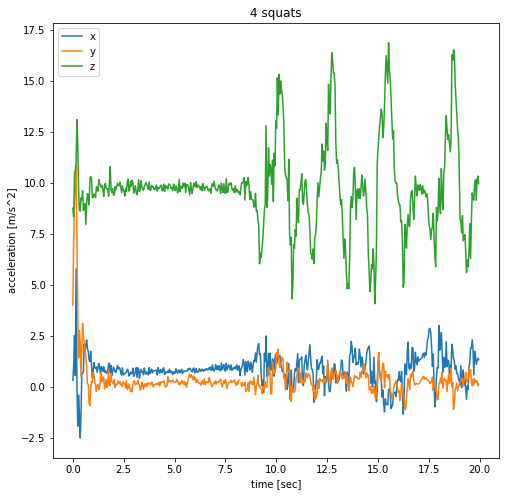

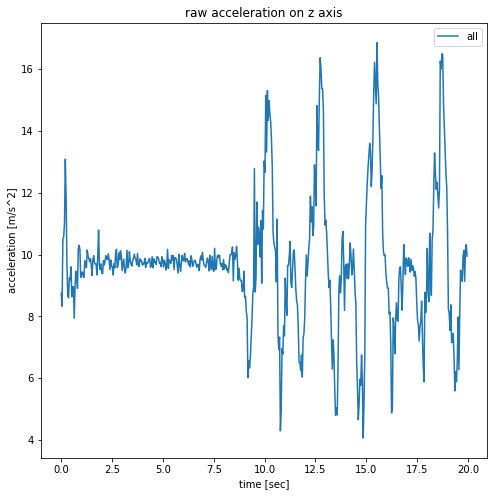

0.479000000000001
0.5589999999999993
0.6379999999999999
0.4789999999999992


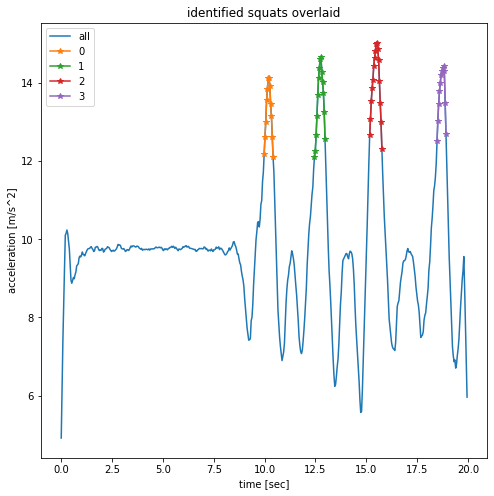

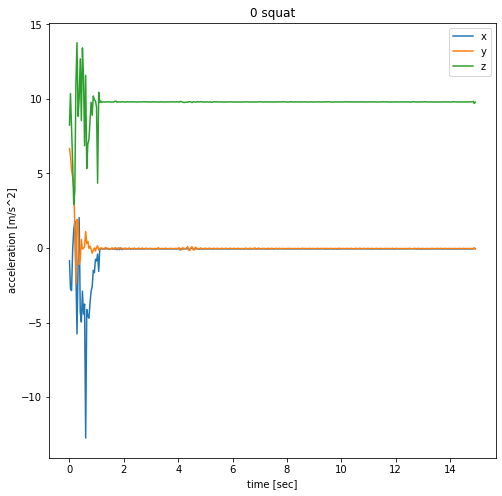

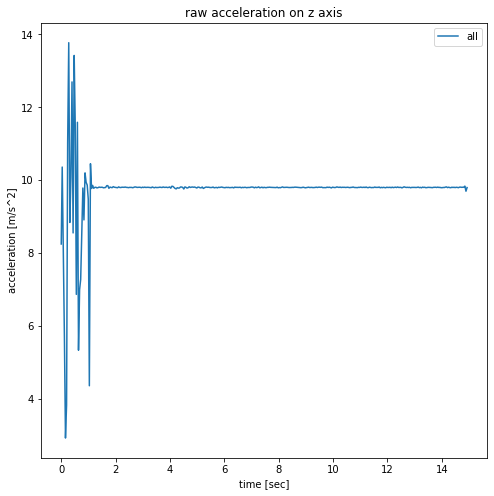

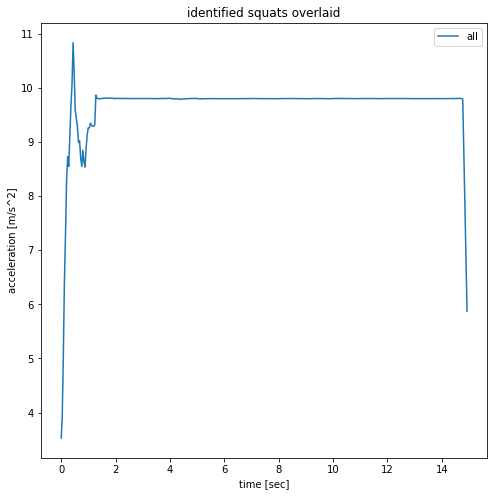

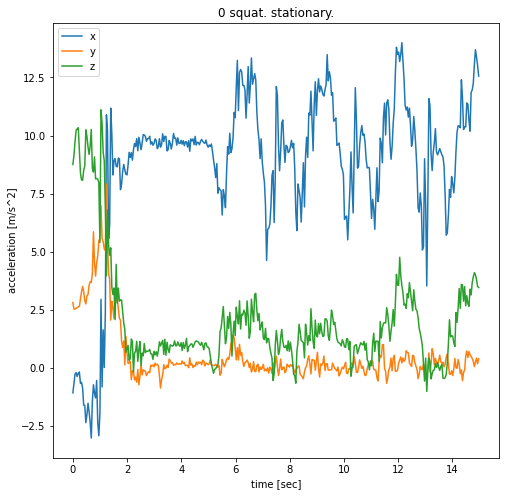

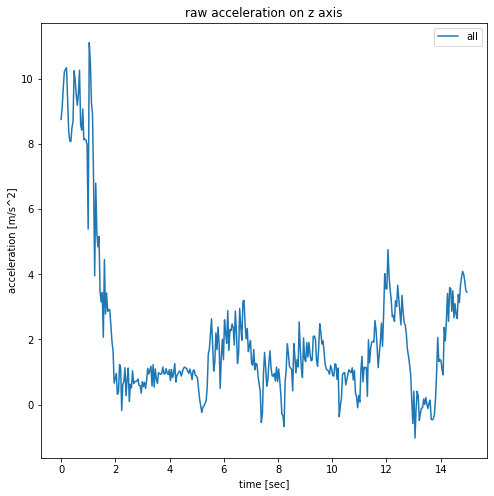

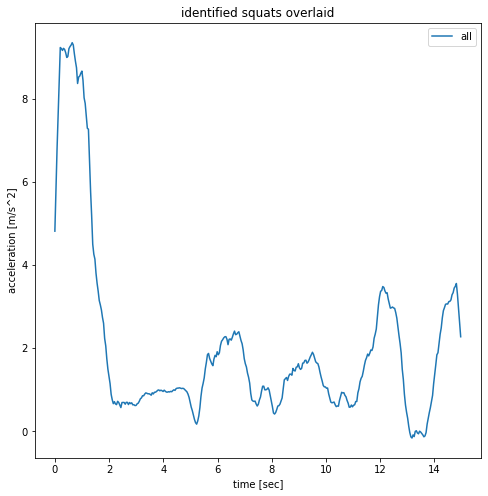

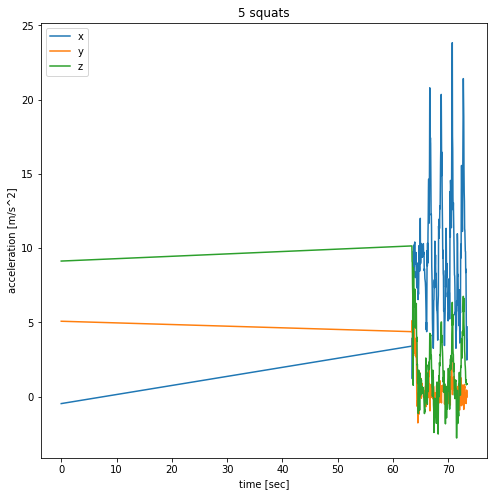

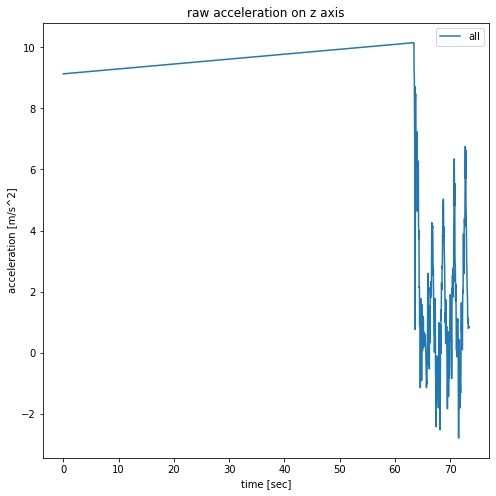

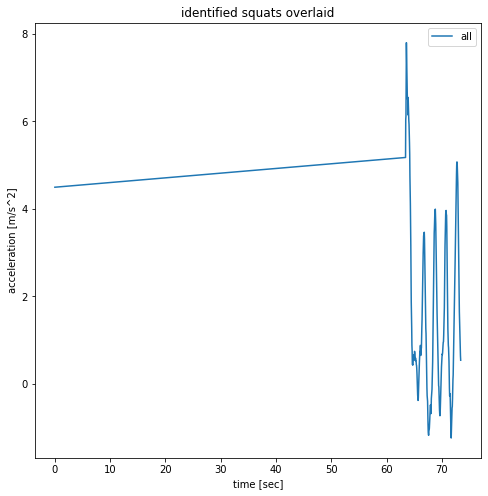

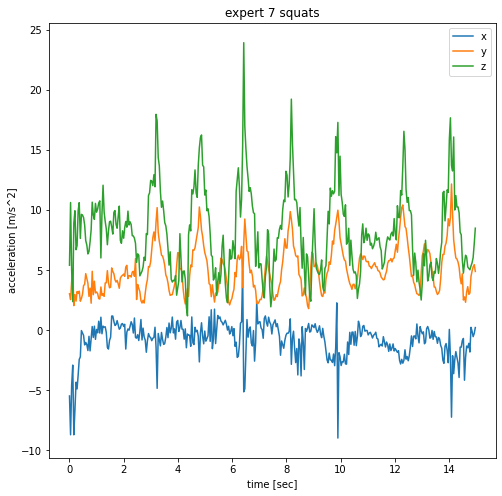

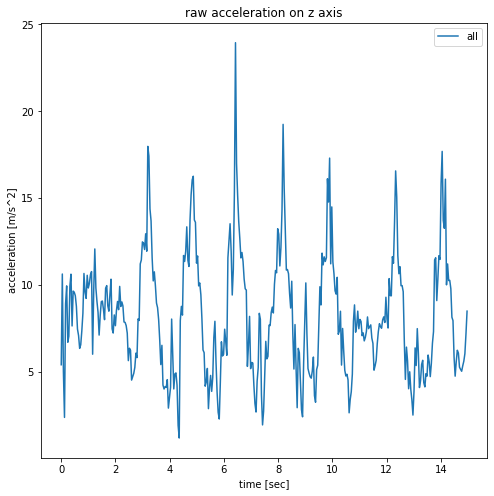

0.359
0.3979999999999997
0.43900000000000006
0.35999999999999943
0.3199999999999985
0.120000000000001
0.35999999999999943


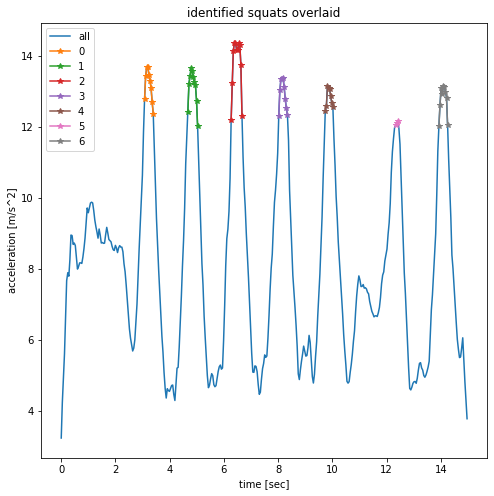

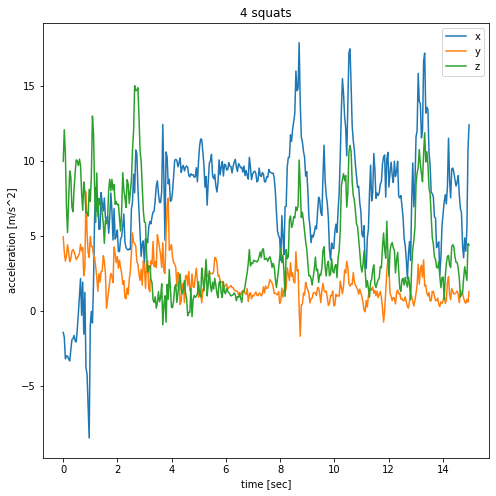

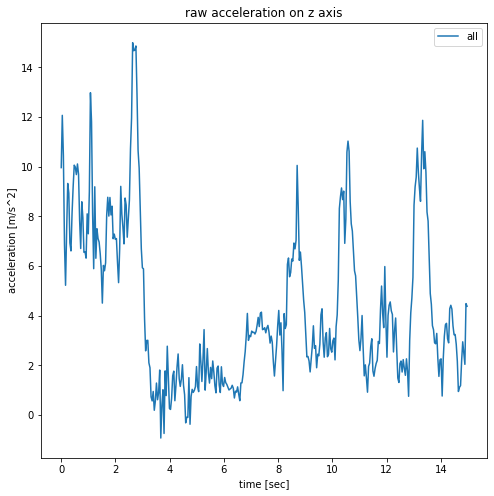

0.1200000000000001


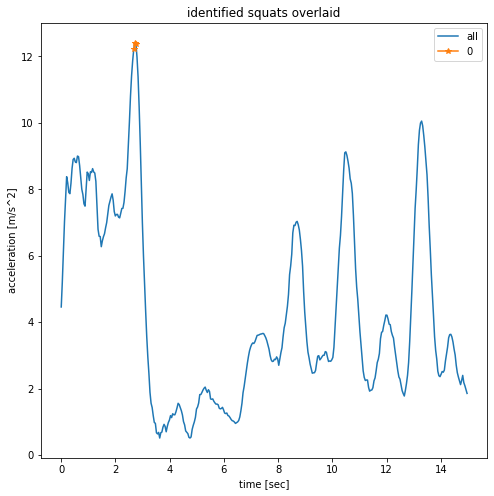

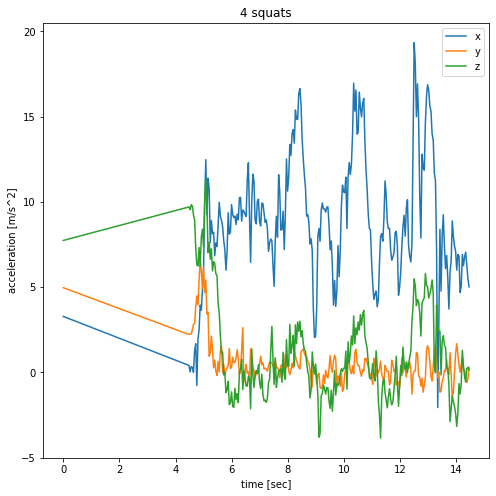

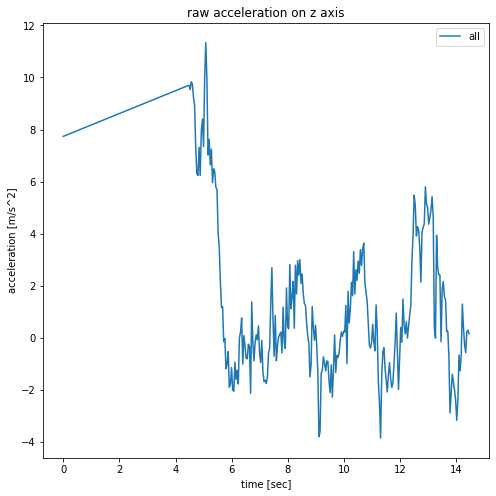

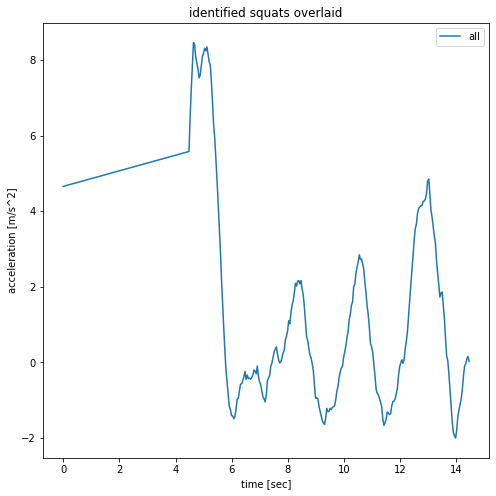

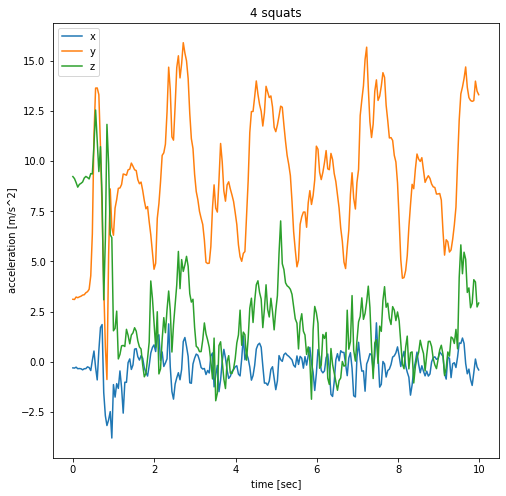

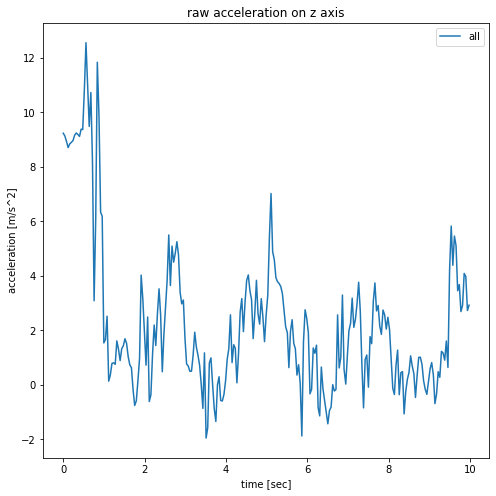

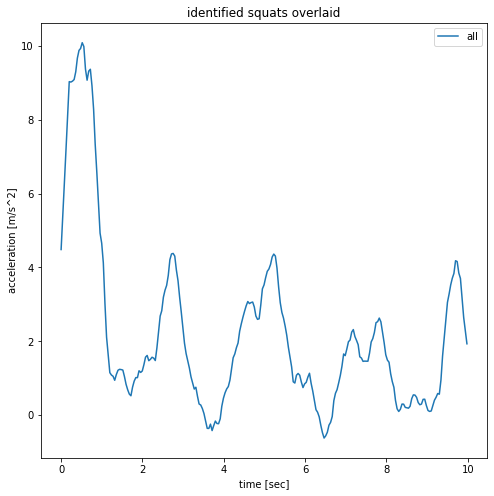

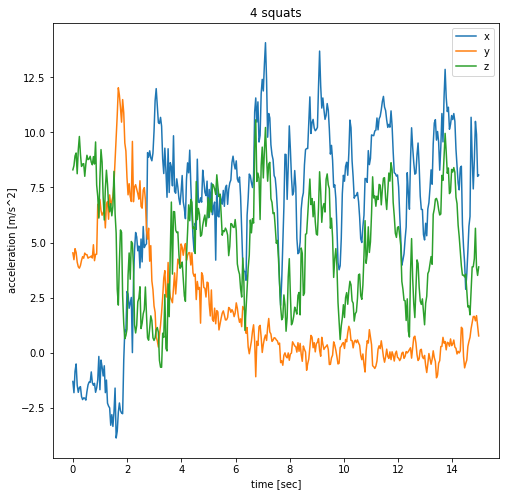

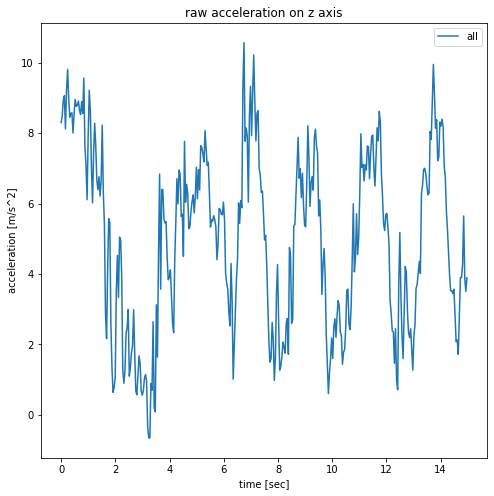

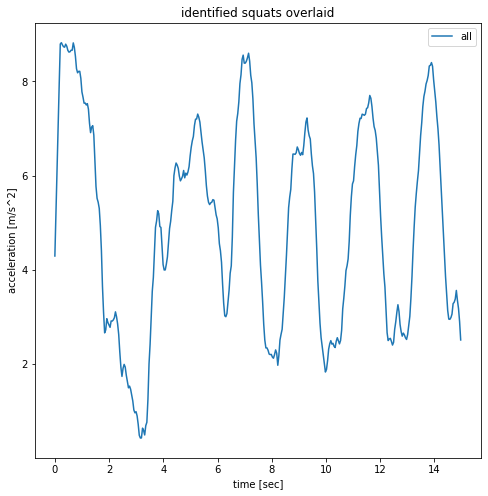

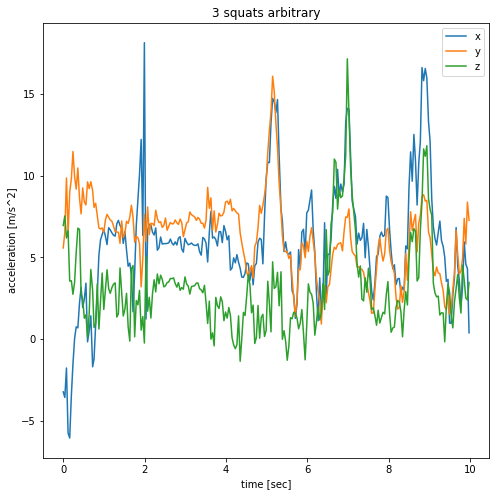

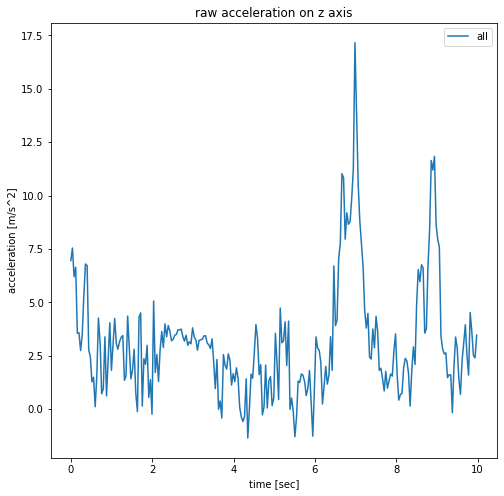

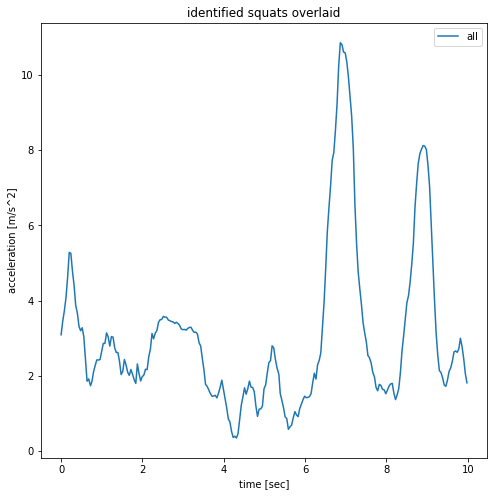

In [3]:
""" go over all the recorded sessions we have on file, and identify squat repetitions,
plotting them out for visualization purposes"""

# get all the sessions we've recorded so far
sessions = client.list_sessions()


# filter the sessions to keep only the ones we've labeled with the tag "squats" from the app

def filter_squat_session(labels):
    """" test if any label contains the word "squat" """
    squat_mentions = []
    for label in labels:
        squat_mentions.append(any(['squat' in label]))
    return any(squat_mentions)


sessions = [session for session in sessions if filter_squat_session(session.labels)]

for session in sessions:

    session_acceleration_data = []
    session_gyro_data = []
    for payload in client.read_session(session_id=session.session_id):
        session_acceleration_data.extend(payload['bundle']['accelerometer_data'])
        session_gyro_data.extend(payload['bundle']['gyroscope_data'])

    df_acceleration = pd.DataFrame.from_records(session_acceleration_data)
    # the gyro data isn't used in this code, but good to kow we can also check out our device orientation
    session_gyro_data = pd.DataFrame.from_records(session_gyro_data)

    if df_acceleration.empty:
        continue
    df_acceleration.rename(columns={'determined_at': 'timestamp'}, inplace=True)
    df_acceleration['timestamp'] = df_acceleration['timestamp'].astype(int)
    df_acceleration.sort_values(by='timestamp', inplace=True)
    # calculate time difference from session start in seconds
    df_acceleration['t'] = (df_acceleration['timestamp'] - df_acceleration['timestamp'].min()) / 1000

    df_acceleration.rename(columns={'determined_at': 'timestamp'}, inplace=True)
    df_acceleration['timestamp'] = df_acceleration['timestamp'].astype(int)
    df_acceleration.sort_values(by='timestamp', inplace=True)
    # calculate time difference from session start in seconds
    df_acceleration['t'] = (df_acceleration['timestamp'] - df_acceleration['timestamp'].min()) / 1000

    plt.figure(figsize=(8, 8))
    plt.plot(df_acceleration['t'], df_acceleration['x'], label='x')
    plt.plot(df_acceleration['t'], df_acceleration['y'], label='y')
    plt.plot(df_acceleration['t'], df_acceleration['z'], label='z')
    plt.legend()

    plt.xlabel('time [sec]')
    plt.ylabel('acceleration [m/s^2]')
    plt.title(' '.join(session.labels))
    plt.show()

    segment_starts, segment_ends = identify_reps(df_acceleration)
    t = df_acceleration['t']
    z = df_acceleration['z']
    plt.figure(figsize=(8, 8))
    plt.plot(t, z, label='all')
    plt.xlabel('time [sec]')
    plt.ylabel('acceleration [m/s^2]')
    plt.legend()
    plt.title('raw acceleration on z axis')
    plt.show()

    filter_length = 10
    df_acceleration_filtered = filter_accelerations(df_acceleration, filter_length)

    segment_starts, segment_ends = identify_reps(df_acceleration_filtered)
    t = df_acceleration_filtered['t']
    z = df_acceleration_filtered['z']
    plt.figure(figsize=(8, 8))
    plt.plot(t, z, label='all')
    i = 0
    for start_loc, end_loc in zip(segment_starts, segment_ends):
        plt.plot(t[start_loc:end_loc], z[start_loc:end_loc], label=str(i), marker='*')
        i += 1
    plt.xlabel('time [sec]')
    plt.ylabel('acceleration [m/s^2]')
    plt.legend()
    plt.title('identified squats overlaid')
    plt.show()


